# Notebook #3

## Outline

- [Load Result from Notebook #2](#Load-Result-from-Notebook-#2)
- [Label Construction](#Label-Construction)
- [Feature Reduction](#Feature-Reduction)
- [Prepare Train and Test Data](#Prepare-train-and-test-data)
   - [Time-dependent Splitting](#Prepare-train-and-test-dataset-using-time-split-method)
   - [Down Sample Negative Examples](#Down-Sample-Negative-examples:)
   - [Cache Results](#Cache-results)
- [Binary Classification Models](#Binary-Classification-Models:)
   - [Random Forest classifier](#Random-Forest-classifier)
   - [Gradient-Boosted Tree classifier](#Gradient-Boosted-Tree-classifier)
   - [Hyper-Parameter Tuning & Cross Validation](#Hyper-Parameter-Tuning-&-Cross-Validation)
   
 <br>

In [1]:
import pyspark.sql.functions as F
import time
import pandas as pd
import subprocess
import sys
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import datetime
import atexit

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import col,udf,lag,date_add,explode,lit,concat,unix_timestamp,sum, abs
from pandas import DataFrame
from pyspark.sql.dataframe import *
from pyspark.ml.classification import *
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.sql.types import DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import Row
from pyspark.ml import Pipeline, PipelineModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, RFormula
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc
from pyspark.sql.functions import month, weekofyear, dayofmonth
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.grid_search import ParameterGrid


/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load Result from Notebook #2 

In [2]:
# load result from Notebook #2 ("FeatureEngineering_RollingCompute")
df = sqlContext.read.parquet('/mnt/resource/PysparkExample/notebook2_result.parquet')

# check the dimension of the dataset and make sure things look right
print(df.count(), len(df.columns))
df.select('key','deviceid').show(3)


(2085102, 1277)
+--------------------+--------+
|                 key|deviceid|
+--------------------+--------+
|N0001_2012-12-08 ...|   N0001|
|N0001_2012-12-09 ...|   N0001|
|N0001_2012-12-10 ...|   N0001|
+--------------------+--------+
only showing top 3 rows



## Label Construction

For predictive maintenance use cases, we usually want to predict failure/problem ahead of time. In our example, we would like to be able to predict machine problem 7 days (failure prediction time window) in advance. That means for the label column, we need to label all the 7 days before the actual failure/problem day as "1". This time window should be picked based on the specific business case: in some situations it may be enough to predict failures hours in advance, while in others days or even weeks might be needed to make meaningful business decision such as allowing enough time for arrival of replacement parts.

To find more detailed information about the label construction technique, please visit [this link](https://pdfs.semanticscholar.org/284d/f4ec85eed338a87fece985246c5bd4f56495.pdf).
<br>

In [3]:
#------------------------------------ Create label column ------------------------------------#

# Step 1: 
df = df.withColumn('label_tmp', col('problemreported')) 

# Step 2:
wSpec = Window.partitionBy('deviceid').orderBy(df.date.desc())
lag_window = 7  # Define how many days in advance we want to predict failure

for i in range(lag_window):
    lag_values = lag(df.label_tmp, default=0).over(wSpec)
    df = df.withColumn('label_tmp', F.when((col('label_tmp')==1) | (lag_values==None) | (lag_values<1) | (lag_values>=(lag_window+1)), col('label_tmp')).otherwise(lag_values+1))

# check the results
print(df.select('label_tmp').distinct().rdd.map(lambda r: r[0]).collect()) 
 

[1, 6, 3, 5, 4, 8, 7, 2, 0]


In [4]:
# Step 3:
### please note that we need to make "label" column double instead of integer for the pyspark classification models 
df = df.withColumn('label', F.when(col('label_tmp') > 0, 1.0).otherwise(0.0))
df.createOrReplaceTempView("df_view") 
 
# Step 4:
df.orderBy('deviceid', 'date').select('deviceid', 'date', 'problemreported', 'label_tmp', 'label').show(20) 


+--------+--------------------+---------------+---------+-----+
|deviceid|                date|problemreported|label_tmp|label|
+--------+--------------------+---------------+---------+-----+
|   N0001|2012-12-08 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-09 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-10 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-11 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-12 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-13 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-14 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-15 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-16 00:00:...|              0|        0|  0.0|
|   N0001|2012-12-17 00:00:...|              0|        8|  1.0|
|   N0001|2012-12-18 00:00:...|              0|        7|  1.0|
|   N0001|2012-12-19 00:00:...|              0|        6|  1.0|
|   N0001|2012-12-20 00:00:...|         

In [5]:
# Visualize the distribution of "label" column
df.select('label').describe().show()


+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|            2085102|
|   mean|0.01456187754843648|
| stddev|0.11979080162007248|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



## Feature Reduction
-  There are not many packages for feature selection in PySpark 2.0.2.,so we decided to use PCA to reduce the demensionality.
-  There are so many features especially rolling features, we need to perform feature selection to reduce the feature set size

In [6]:
## check the number of rolling features
len([col_n for col_n in df.columns if '_rolling' in col_n])


1150

In [7]:
# Step 1
# Use RFormula to create the feature vector
rolling_features = list(s for s in df.columns if "_rolling" in s)
formula = RFormula(formula = "~" + "+".join(rolling_features))
output = formula.fit(df).transform(df).select("key","features") 


# Step 2 
# Before PCA, we need to standardize the features, it is very important...
# We compared 1) standardization, 2) min-max normalization, 3) combintion of standardization and min-max normalization
# In 2), the 1st PC explained more than 67% of the variance
# 1) & 3) generate exactly the same results for model.explainedVariance. 
# That means min-max normalization does not help in our case

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(output)


# Step 3
pca = PCA(k=50, inputCol="scaledFeatures", outputCol="pca_roll_features")
model = pca.fit(scaledData)
result = model.transform(scaledData).select("key","pca_roll_features")
print(model.explainedVariance)


# Step 4
df = df.join(result, 'key', 'inner')
rolling_drop_list = [col_n for col_n in df.columns if '_rolling' in col_n]
df = df.select([column for column in df.columns if column not in rolling_drop_list])

df.select('key','pca_roll_features').show(5)


[0.0720783785227,0.0329825870736,0.027901485354,0.0243662075346,0.0231109612038,0.0230696286064,0.0175345239922,0.0169050432163,0.0160163382589,0.0151685106261,0.0139611893027,0.0132999118492,0.0128137208726,0.012460010309,0.0123226258655,0.0121766225655,0.0110137480593,0.0106161694018,0.0103270115698,0.00977105423534,0.00908164998253,0.00880547728788,0.00839688758961,0.00833527942731,0.00816512952224,0.00807362710216,0.00787447043078,0.00782728526041,0.00776590544977,0.00753956685426,0.00735611311084,0.00717316781783,0.00710561994143,0.00694768452248,0.0068423949855,0.00669806943767,0.00660469671941,0.00658491264526,0.00646747772504,0.00638036477672,0.00630822833773,0.00628238685298,0.00608372864476,0.00606093314036,0.00604486211127,0.00599575013941,0.00591032102729,0.0057055133175,0.00568659059503,0.00551330593664]
+--------------------+--------------------+
|                 key|   pca_roll_features|
+--------------------+--------------------+
|N0001_2012-12-08 ...|[0.0,0.0,0.0,0.0,

# Prepare train and test data

In [8]:
# Define list of input columns for downstream modeling
input_features = [
 'usage_count_1',
 'usage_count_2',
 'problem_type_1',
 'problem_type_2',
 'problem_type_3',
 'problem_type_4',
 'error_count_1',
 'error_count_2',
 'error_count_3',
 'error_count_4',
 'error_count_5',
 'error_count_6',
 'error_count_7',
 'error_count_8',
 'month',
 'weekofyear',
 'dayofmonth',
 'warn_type1_total',
 'warn_type2_total',
 'fault_code_type_1_count',
 'fault_code_type_2_count',
 'fault_code_type_3_count',
 'fault_code_type_4_count',
 'problem_type_1_per_usage1',
 'problem_type_2_per_usage1',
 'problem_type_3_per_usage1',
 'problem_type_4_per_usage1',
 'fault_code_type_1_count_per_usage1',
 'fault_code_type_2_count_per_usage1',
 'fault_code_type_3_count_per_usage1',
 'fault_code_type_4_count_per_usage1',
 'problem_type_1_per_usage2',
 'problem_type_2_per_usage2',
 'problem_type_3_per_usage2',
 'problem_type_4_per_usage2',
 'fault_code_type_1_count_per_usage2',
 'fault_code_type_2_count_per_usage2',
 'fault_code_type_3_count_per_usage2',
 'fault_code_type_4_count_per_usage2',   
 'problem_type_1_category_encoded',
 'problem_type_2_category_encoded',
 'problem_type_3_category_encoded',
 'problem_type_4_category_encoded',
 'problem_type_1_per_usage1_category_encoded',
 'problem_type_2_per_usage1_category_encoded',
 'problem_type_3_per_usage1_category_encoded',
 'problem_type_4_per_usage1_category_encoded',
 'problem_type_1_per_usage2_category_encoded',
 'problem_type_2_per_usage2_category_encoded',
 'problem_type_3_per_usage2_category_encoded',
 'problem_type_4_per_usage2_category_encoded',
 'fault_code_type_1_count_category_encoded',
 'fault_code_type_2_count_category_encoded',
 'fault_code_type_3_count_category_encoded',
 'fault_code_type_4_count_category_encoded',
 'fault_code_type_1_count_per_usage1_category_encoded',
 'fault_code_type_2_count_per_usage1_category_encoded',
 'fault_code_type_3_count_per_usage1_category_encoded',
 'fault_code_type_4_count_per_usage1_category_encoded',
 'fault_code_type_1_count_per_usage2_category_encoded',
 'fault_code_type_2_count_per_usage2_category_encoded',
 'fault_code_type_3_count_per_usage2_category_encoded',
 'fault_code_type_4_count_per_usage2_category_encoded',
 'cat1_encoded',
 'cat2_encoded',
 'cat3_encoded',
 'cat4_encoded',     
 'pca_1_warn',
 'pca_2_warn',
 'pca_3_warn',
 'pca_4_warn',
 'pca_5_warn',
 'pca_6_warn',
 'pca_7_warn',
 'pca_8_warn',
 'pca_9_warn',
 'pca_10_warn',
 'pca_11_warn',
 'pca_12_warn',
 'pca_13_warn',
 'pca_14_warn',
 'pca_15_warn',
 'pca_16_warn',
 'pca_17_warn',
 'pca_18_warn',
 'pca_19_warn',
 'pca_20_warn',
 'pca_roll_features'
]

label_var = ['label']
key_cols =['key','deviceid','date']


In [9]:
# Assemble features
va = VectorAssembler(inputCols=(input_features), outputCol='features')
df = va.transform(df).select('deviceid','date','label','features')


In [10]:
# Set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(df)
    

### Remember to do “StringIndexer” on the label column, fit on the entire dataset to include all labels in index. Also, the label column has to be Double instead of Integer type.  

In [11]:
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)


### Prepare train and test dataset using time split method 
-  training data: year 2012-2014
-  testing data: year 2015

In [12]:
training = df.filter(df.date > "2011-12-31").filter(df.date < "2015-01-01")
testing = df.filter(df.date > "2014-12-31")

print(training.count())
print(testing.count())


1431846
655155


In [13]:
## show the distribution of label "0" and "1"
df.groupby('label').count().show()


+-----+-------+
|label|  count|
+-----+-------+
|  0.0|2054739|
|  1.0|  30363|
+-----+-------+



### Down-Sample Negative examples:
-  This is a ***highly umbalanced data*** with way more label "0" than "1" ("1" only accounts for 1.5%).
-  So we need to down sample the negatives while keeping all positive samples.
-  To make label "1" to "0" ratio close to 1:10 (you can use other ratio for example 1:5), we need to down-sample the "0"s (take 13.5% of all the label "0"s)

In [14]:
# SampleBy returns a stratified sample without replacement based on the fraction given on each stratum
train_downsampled = training.sampleBy('label', fractions={0.0: 0.135, 1.0: 1.0}, seed=123).cache()
train_downsampled.groupby('label').count().show()

testing.groupby('label').count().show()


+-----+------+
|label| count|
+-----+------+
|  0.0|190823|
|  1.0| 20777|
+-----+------+

+-----+------+
|label| count|
+-----+------+
|  0.0|645547|
|  1.0|  9608|
+-----+------+



### Cache results 

Do it when necessary especially if your downstream work (e.g. recursive modeling) use that data over and over again. Here in our case, after the train and test datasets are prepared, we cache them in memory. 

In [15]:
# cache datasets in memory
train_downsampled.cache()
testing.cache()

# check the number of devices in training and testing data
print(train_downsampled.select('deviceid').distinct().count())
print(testing.select('deviceid').distinct().count())


1899
1899


In [16]:
# Set model storage directory path. This is where models will be saved.
modelDir = "/mnt/resource/PysparkExample/Outputs/"; 

## Binary Classification Models:
-  Random Forest classifier
-  Gradient-Boosted Tree

### Random Forest classifier

In [17]:
%%time

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# Chain indexers and forest in a Pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf])

# Train model.  This also runs the indexers.
model_rf = pipeline_rf.fit(train_downsampled)

# Save model
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
rf_fileName = "RandomForest_" + datestamp;
rfDirfilename = modelDir + rf_fileName;
model_rf.save(rfDirfilename)

# Make predictions.
predictions_rf = model_rf.transform(testing)
predictions_rf.groupby('indexedLabel', 'prediction').count().show()


+------------+----------+------+
|indexedLabel|prediction| count|
+------------+----------+------+
|         1.0|       1.0|   478|
|         0.0|       1.0|  1746|
|         1.0|       0.0|  9130|
|         0.0|       0.0|643801|
+------------+----------+------+

CPU times: user 20.5 ms, sys: 13.6 ms, total: 34.1 ms
Wall time: 28.8 s


In [18]:
predictions_rf.dtypes

[('deviceid', 'string'),
 ('date', 'timestamp'),
 ('label', 'double'),
 ('features', 'vector'),
 ('indexedLabel', 'double'),
 ('indexedFeatures', 'vector'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double')]

Area under ROC = 0.600472
Area under PR = 0.133672

Accuracy = 0.983399
Weighted Precision = 0.974709
Weighted Recall = 0.983399
F1 = 0.978267


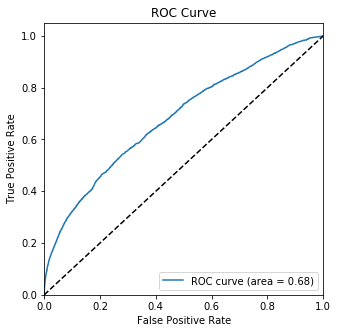

CPU times: user 1min 22s, sys: 786 ms, total: 1min 23s
Wall time: 2min 14s


In [19]:
%%time

predictionAndLabels = predictions_rf.select("indexedLabel", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"}))

# PLOT ROC curve after converting predictions to a Pandas dataframe
%matplotlib inline
predictions_rf_pddf = predictions_rf.select('indexedLabel','probability').toPandas()
labels = predictions_rf_pddf["indexedLabel"]
prob = []
for dv in predictions_rf_pddf["probability"]:
    prob.append(dv.values[1])
     
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1.0);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


#### Pyspark MulticlassClassificationEvaluator in version 2.0.2 only gives weighted precision and recall. But we would also like to see the raw precision and recall as well.

In [20]:
# Use sklearn
rf_result = predictions_rf.select('indexedLabel', 'prediction').toPandas()

rf_label = rf_result['indexedLabel'].tolist()
rf_prediction = rf_result['prediction'].tolist()

precision, recall, fscore, support = score(rf_label, rf_prediction)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: [ 0.9860169   0.21492806]
recall: [ 0.99729532  0.04975021]
fscore: [ 0.99162404  0.08079784]
support: [645547   9608]


### Gradient-Boosted Tree classifier

In [21]:
%%time

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxDepth=10, minInstancesPerNode=5, maxIter=50)

# Chain indexers and GBT in a Pipeline
pipeline_gbt = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model_gbt = pipeline_gbt.fit(train_downsampled)

# save model
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
gbt_fileName = "GradientBoostedTree_" + datestamp;
gbtDirfilename = modelDir + gbt_fileName;
model_gbt.save(gbtDirfilename)

# Make predictions.
predictions_gbt = model_gbt.transform(testing)


CPU times: user 127 ms, sys: 13.1 ms, total: 140 ms
Wall time: 12min 9s


In [22]:
# show prediction results
predictions_gbt.groupby('indexedLabel', 'prediction').count().show()


+------------+----------+------+
|indexedLabel|prediction| count|
+------------+----------+------+
|         1.0|       1.0|   831|
|         0.0|       1.0|  6332|
|         1.0|       0.0|  8777|
|         0.0|       0.0|639215|
+------------+----------+------+



In [23]:
%%time

predictionAndLabels = predictions_gbt.select("indexedLabel", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions_gbt, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions_gbt, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions_gbt, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions_gbt, {evaluator.metricName: "f1"}))


Area under ROC = 0.551234
Area under PR = 0.106084

Accuracy = 0.976938
Weighted Precision = 0.97369
Weighted Recall = 0.976938
F1 = 0.975279
CPU times: user 54.4 ms, sys: 20.3 ms, total: 74.7 ms
Wall time: 40.6 s


In [24]:
# Use sklearn to calculate the raw precision and recall

gbt_result = predictions_gbt.select('indexedLabel', 'prediction').toPandas()

gbt_label = gbt_result['indexedLabel'].tolist()
gbt_prediction = gbt_result['prediction'].tolist()

precision, recall, fscore, support = score(gbt_label, gbt_prediction)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: [ 0.98645508  0.11601284]
recall: [ 0.99019126  0.08649042]
fscore: [ 0.98831964  0.09909964]
support: [645547   9608]


### Comparing results from Random Forest and Gradient Boosted Tree:
-  Gradient Boosted Tree gives better recall but worse precision compared with Random Forest. For most of the predictive maintenance use cases, the business cost associated with false positives is usually expensive. There is always a trade-off between precision and recall. We want to achieve higher precision rate (fewer false positives) even though that might compromise the recall rate.
-  That is why we decided to go with Random Forest model and further optimized it with hyper-parametre tuning.

## Hyper-Parameter Tuning & Cross Validation

Train a random forest classification model using hyper-parameter tuning and cross-validation

In [25]:
%%time

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", 
                            featureSubsetStrategy="auto", impurity="gini", seed=123)

# Chain indexers and forest in a Pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf])


## Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxBins, [10, 20]) \
    .addGrid(rf.maxDepth, [3, 5, 7]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .build()

## Define cross-validation
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="weightedPrecision"),
                          numFolds=3)

## Train model using CV
cvModel = crossval.fit(train_downsampled)

## Predict and evaluate
predictions = cvModel.transform(testing)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
r2 = evaluator.evaluate(predictions)
print("weightedPrecision on test data = %g" % r2)

## Save the best model
fileName = "CV_RandomForestClassificationModel_" + datestamp;
CVDirfilename = modelDir + fileName;
cvModel.bestModel.save(CVDirfilename);


weightedPrecision on test data = 0.97472
CPU times: user 3.4 s, sys: 1.8 s, total: 5.2 s
Wall time: 54min 1s


#### Hyper-parameter tuning only improved the model performance a little bit. We will then use that model for future scoring.